In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
path_to_dataset = "../../public_data"
#path_to_dataset = "/fastdata/dcarrion/meta-album"

# Confidence Estimation

In [3]:
import pathlib
import cdmetadl

PROJECT_DIR = pathlib.Path(cdmetadl.__file__).parent.parent

In [4]:
import pathlib

import cdmetadl.helpers.general_helpers
import cdmetadl.dataset

dataset_path = pathlib.Path(path_to_dataset)
dataset_info_dict = cdmetadl.helpers.general_helpers.check_datasets(dataset_path, ["SPT"])

dataset = cdmetadl.dataset.ImageDataset("Sports", dataset_info_dict["SPT"])

In [5]:
import cdmetadl.samplers

n_way_sampler = cdmetadl.samplers.ValueSampler(value=5)
k_shot_sampler = cdmetadl.samplers.ValueSampler(value=4)

task = dataset.generate_task(n_way_sampler, k_shot_sampler, query_size=4)

In [6]:
import cdmetadl.helpers.general_helpers

model_module = cdmetadl.helpers.general_helpers.load_module_from_path(PROJECT_DIR / "baselines/finetuning/model.py")
learner = model_module.MyLearner()
learner.load(PROJECT_DIR / "output/full/training/dropout_50/finetuning/cross-domain/model")

## Pseudo Confidence Estimation

[0.20548713207244873, 0.0, 0.0, 0.0, 0.0]


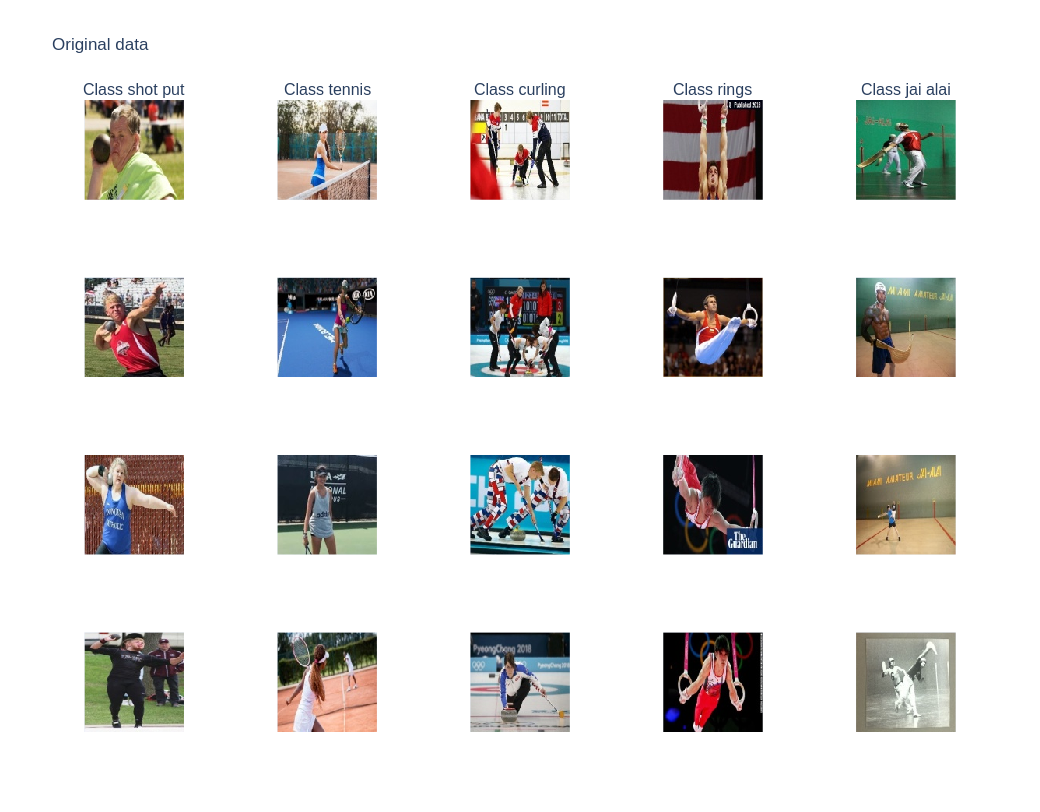

In [7]:
import cdmetadl.confidence
import cdmetadl.notebooks.helpers

confidence_estimator = cdmetadl.confidence.PseudoConfidenceEstimator()
_, confidence_scores = confidence_estimator.estimate(learner, task.query_set)
print(confidence_scores)

fig = cdmetadl.notebooks.helpers.show_images_grid_plotly(task.support_set, True)

## Monte Carlo Dropout Confidence Estimation

[0.3511226549744607, 0.42502049356699, 0.4285087622702123, 0.5940384976565838, 0.4326108656823636]


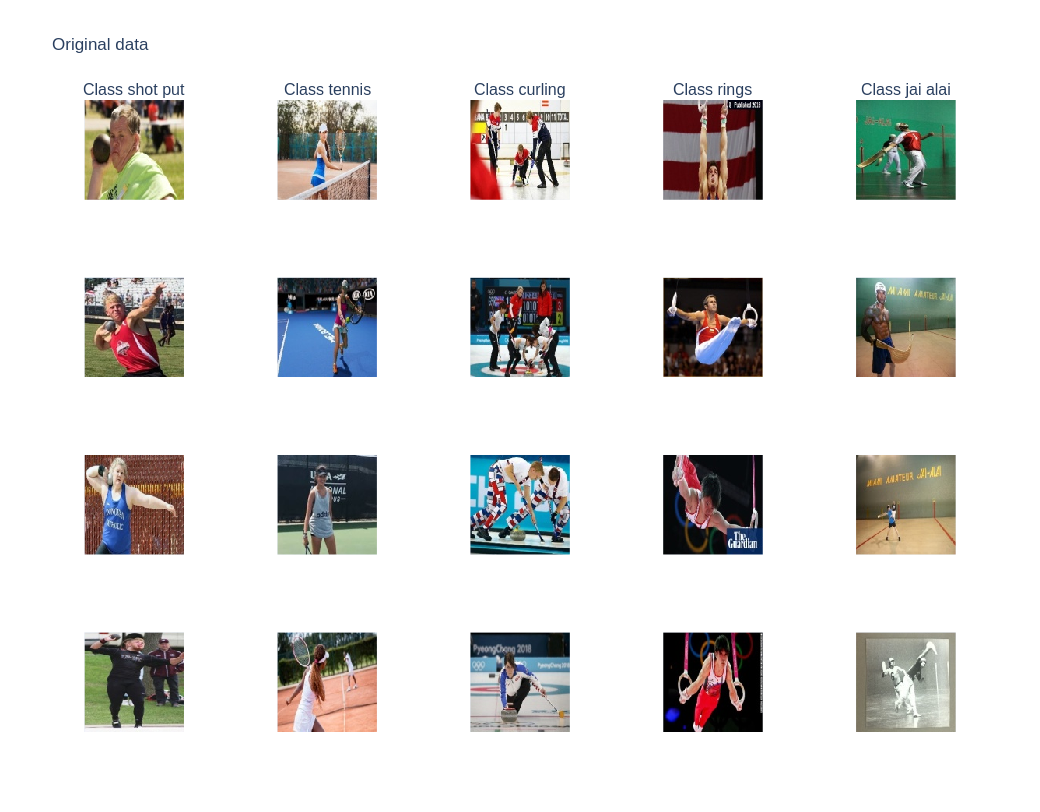

In [8]:
import cdmetadl.confidence
import cdmetadl.notebooks.helpers

confidence_estimator = cdmetadl.confidence.MCDropoutConfidenceEstimator()
_, confidence_scores = confidence_estimator.estimate(learner, task.query_set)
print(confidence_scores)

fig = cdmetadl.notebooks.helpers.show_images_grid_plotly(task.support_set, True)